In [91]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils_v1a import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils_v1a import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from copy import deepcopy

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
def update_parameters_with_gd(parameters , grads, learning_rate ):
    L = len(parameters) //2
    for l in range(1,L+1):
       parameters["W" + str(l)] = parameters['W' + str(l)] - (learning_rate * grads["dW" + str(l)])
       parameters["b" + str(l)] = parameters['b' + str(l)] - (learning_rate * grads["db" + str(l)])

    return parameters

In [93]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    np.random.seed(seed)            
    m = X.shape[1]                  
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    inc = mini_batch_size

    num_complete_minibatches = math.floor(m / mini_batch_size) 
    for k in range(0, num_complete_minibatches):
        
        mini_batch_X = shuffled_X[:, mini_batch_size * k : mini_batch_size * (k+1)]
        mini_batch_Y = shuffled_Y[:, mini_batch_size * k : mini_batch_size * (k+1)]
 
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    
    if m % mini_batch_size != 0:
      
        mini_batch_X = shuffled_X[: , num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[: , num_complete_minibatches * mini_batch_size : m]
    
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### Momentum

In [94]:
def initialize_velocity(parameters):

    L = len(parameters) //2 
    v = {}
    

    for l in range(1, L + 1):
 
        v['dW' + str(l)] = np.zeros_like(parameters['W' + str(l)])
        v['db' + str(l)] = np.zeros_like(parameters['b' + str(l)])

    return v

In [95]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):

    L = len(parameters) //2

    for l in range(1, L + 1):

        v['dW' + str(l)] = (beta * v['dW' +str(l)]) + (1 - beta) * (grads['dW' + str(l)])
        v['db' + str(l)] = (beta * v['db' +str(l)]) + (1 - beta) * (grads['db' + str(l)])
        parameters['W' + str(l)] = parameters['W' + str(l)]  - (learning_rate * v['dW' + str(l)])
        parameters['b' + str(l)] = parameters['b' + str(l)]  - (learning_rate * v['db' + str(l)])
        
    return parameters, v

### Adam

In [96]:
def initialize_adam(parameters):
    L = len(parameters) //2
    v = {}
    s = {}

    for l in range(1, L+1):
        v['dW' + str(l)] = np.zeros_like(parameters['W' + str(l)])
        v['db' + str(l)] = np.zeros_like(parameters['b' + str(l)])

        s['dW' + str(l)] = np.zeros_like(parameters['W' + str(l)])
        s['db' + str(l)] = np.zeros_like(parameters['b' + str(l)])

    return v, s    

In [97]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):

    L = len(parameters) // 2                 
    v_corrected = {}                         
    s_corrected = {}                         
    

    for l in range(1, L + 1):
 
        v['dW' + str(l)] = beta1 * v['dW' + str(l)] + (1 - beta1) * grads['dW' + str(l)]
        v['db' + str(l)] = beta1 * v['db' + str(l)] + (1 - beta1) * grads['db' + str(l)]
    
        v_corrected['dW' + str(l)] = v['dW' + str(l)]/(1 -beta1**t)
        v_corrected['db' + str(l)] = v['db' + str(l)]/(1 -beta1**t)

        s['dW' + str(l)] = beta2 * s['dW' + str(l)] + (1 - beta2) * np.square(grads['dW' + str(l)])
        s['db' + str(l)] = beta2 * s['db' + str(l)] + (1 - beta2) * np.square(grads['db' + str(l)])

        s_corrected['dW' + str(l)] = s['dW' + str(l)]/(1 - beta2**t)
        s_corrected['db' + str(l)] = s['db' + str(l)]/(1 - beta2**t)

        parameters['W' + str(l)] = parameters['W' + str(l)] - (learning_rate * (v_corrected['dW'+ str(l)])/(np.sqrt(s_corrected['dW'+ str(l)]) + epsilon))
        parameters['b' + str(l)] = parameters['b' + str(l)] - (learning_rate * (v_corrected['db'+ str(l)])/(np.sqrt(s_corrected['db'+ str(l)]) + epsilon))
  

    return parameters, v, s, v_corrected, s_corrected

### Dataset

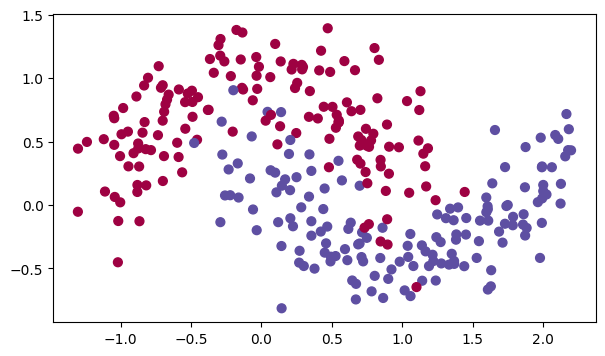

In [98]:
train_X, train_Y = load_dataset()

### Testing the model with created optimizers

In [99]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True):

    L = len(layers_dims)             
    costs = []                       
    t = 0                            
    seed = 10                    
    m = X.shape[1]                   
    

    parameters = initialize_parameters(layers_dims)

   
    if optimizer == "gd":
        pass 
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    
    for i in range(num_epochs):
        
    
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

         
            (minibatch_X, minibatch_Y) = minibatch

           
            a3, caches = forward_propagation(minibatch_X, parameters)

            
            cost_total += compute_cost(a3, minibatch_Y)

         
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

           
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
 
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

### Mini-batch Gradient Descent

Cost after epoch 0: 0.702405
Cost after epoch 1000: 0.668101
Cost after epoch 2000: 0.635288
Cost after epoch 3000: 0.600491
Cost after epoch 4000: 0.573367


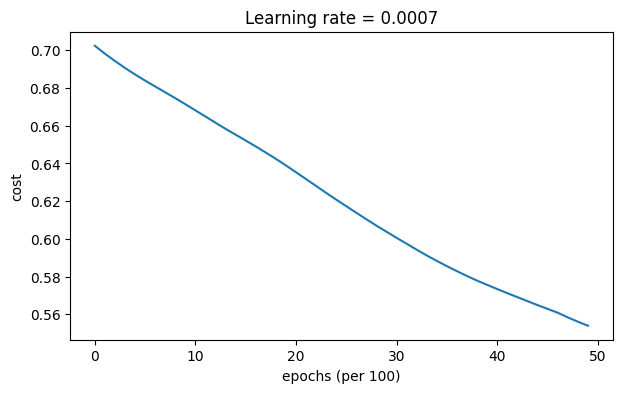

Accuracy: 0.7166666666666667


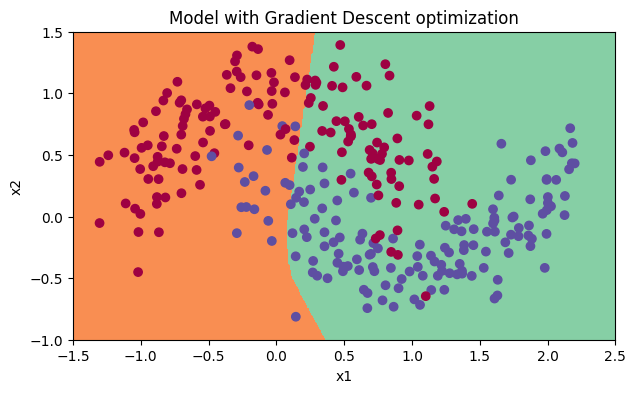

In [100]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Mini-batch Gradient Descent with Momentum

Cost after epoch 0: 0.702413
Cost after epoch 1000: 0.668167
Cost after epoch 2000: 0.635388
Cost after epoch 3000: 0.600591
Cost after epoch 4000: 0.573444


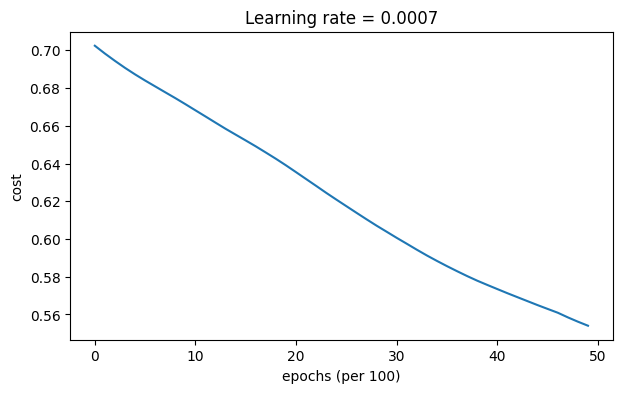

Accuracy: 0.7166666666666667


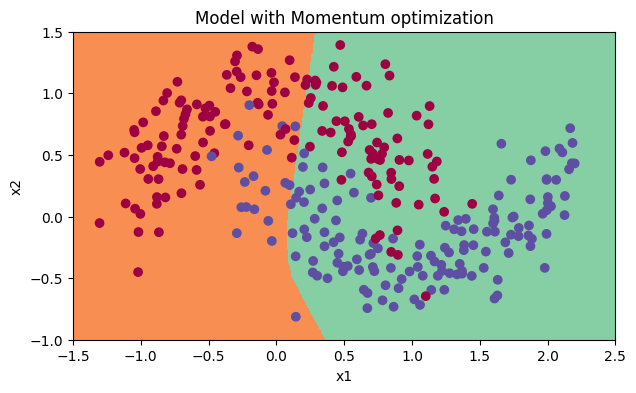

In [101]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Mini-batch Gradient Descent with Adam

Cost after epoch 0: 0.702166
Cost after epoch 1000: 0.167845
Cost after epoch 2000: 0.141316
Cost after epoch 3000: 0.138788
Cost after epoch 4000: 0.136066


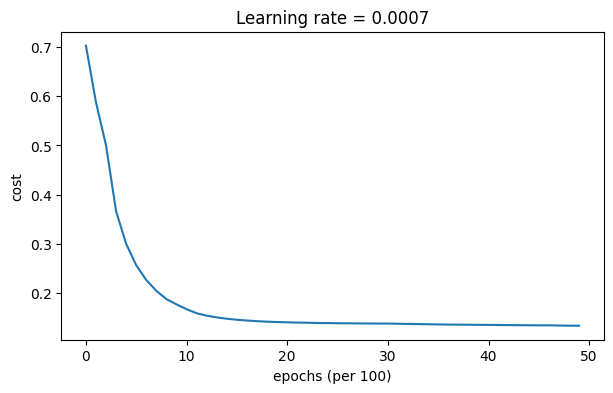

Accuracy: 0.9433333333333334


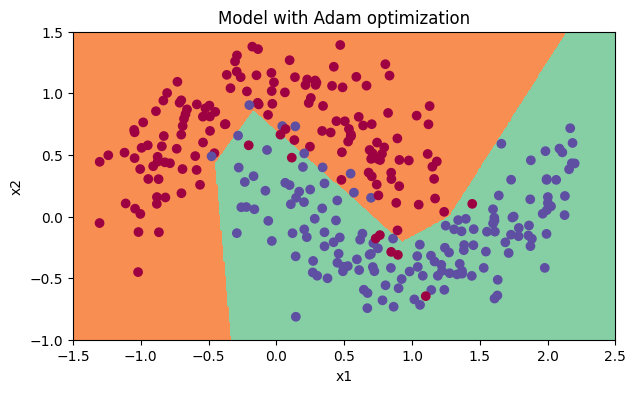

In [102]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)